In this notebook, we will apply PCA as new features to enhance our model performance on Ames dataset, and detect outlier using PCA

In [68]:
#import essential libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

#set Matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes',
      labelweight='bold',
      labelsize='large',
      titleweight='bold',
      titlesize=14,
      titlepad=10,)

def apply_pca(X, standardize=True):
    #Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    #create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    #Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    #create loadings
    loadings = pd.DataFrame(pca.components_.T, #transpose the matrix of loadings
                           columns=component_names, #columns are the pc names
                           index=X.columns, #the rows are the original features
                           )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    #create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n+1)
    #explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
    #Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
    
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y):
    X = X.copy()
    #label enconding
    for colname in X.select_dtypes(['object', 'category']):
        X[colname], _ = X[colname].factorize()
    #All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(i) for i in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    #Label encoding for categoricals
    for colname in X.select_dtypes(['category', 'object']):
        X[colname], _ = X[colname].factorize()
    #Metric for evaluation
    score = cross_val_score(model, X, y, scoring='neg_mean_squared_log_error')
    
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score



In [69]:
df = pd.read_csv("./data/house-prices-advanced-regression-techniques/ames.csv")
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal,189900


In [77]:
#evaluate correlation between features and target
corr_features = df.columns.to_list()
corr_features.remove('SalePrice')
print(df[corr_features].corrwith(df.SalePrice).sort_values(ascending=False))

GrLivArea           0.706780
GarageCars          0.647562
GarageArea          0.640138
TotalBsmtSF         0.632529
FirstFlrSF          0.621676
YearBuilt           0.558426
FullBath            0.545604
YearRemodAdd        0.532974
MasVnrArea          0.502196
TotRmsAbvGrd        0.495474
Fireplaces          0.474558
WoodDeckSF          0.327143
OpenPorchSF         0.312951
HalfBath            0.285056
BsmtFullBath        0.275823
SecondFlrSF         0.269373
LotArea             0.266549
LotFrontage         0.201875
BsmtUnfSF           0.183308
BedroomAbvGr        0.143913
ScreenPorch         0.112151
PoolArea            0.068403
MoSold              0.035259
Threeseasonporch    0.032225
BsmtFinSF2          0.006018
MiscVal            -0.015691
YearSold           -0.030569
BsmtHalfBath       -0.035817
LowQualFinSF       -0.037660
KitchenAbvGr       -0.119814
EnclosedPorch      -0.128787
BsmtFinSF1         -0.134905
dtype: float64


/var/folders/rn/ljpx9hjx4yvftbhwbld6fwjc0000gn/T/ipykernel_59794/2178120247.py:4: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df[corr_features].corrwith(df.SalePrice).sort_values(ascending=False))


In [71]:
#choose a few features to apply PCA, GrLivArea, GarageArea, YearRemodAdd, TotalBsmtSF
features = ['GrLivArea', 'GarageArea', 'YearRemodAdd', 'TotalBsmtSF']

X = df.copy()
y = X.pop('SalePrice')
X = X.loc[:, features]

#apply PCa
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                   PC1       PC2       PC3       PC4
GrLivArea     0.514294  0.270700  0.742592 -0.332837
GarageArea    0.541229  0.102375 -0.038470  0.833733
YearRemodAdd  0.427077 -0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076  0.360778 -0.666836 -0.406192


#### Interpret Component Loadings
Look at PC1, we can see all of this features have same sign, they all positive, they vary in the same direction. PC3, the significant constrast features in PC3 are GrLivArea and TotalBsmtSF, indicates houses with a lot of living are will likely to have no or small basements, and opposite

we will use this results of PCA to discover one or more new features which improve the performance of our model.


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

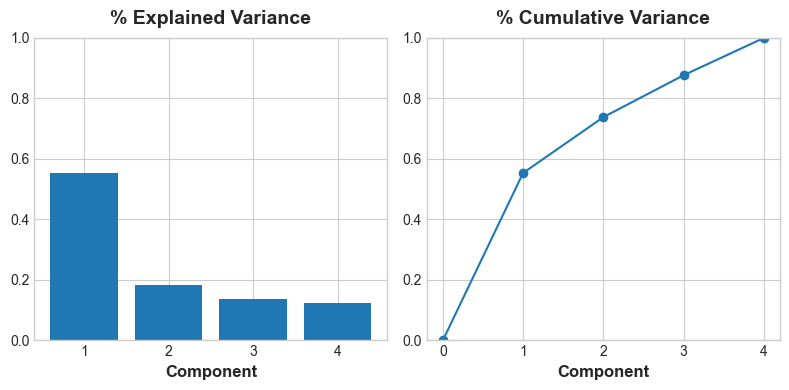

In [72]:
#Plotting Variance
plot_variance(pca)

In [84]:
#As we explained early, we will add new features explained by PC1 and PC3
X = df.copy()
y = X.pop('SalePrice')

#Add new features, explained by PC1 and PC3
X['Feature1'] = X.GrLivArea + X.TotalBsmtSF
X['Feature2'] = X.YearRemodAdd * X.TotalBsmtSF

#scoring model
score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.13361 RMSLE


#### Detect Outlier with PCA
Another useful way is we can use PCA to detect outliers in the dataset(data points that are unusually extreme in some way). Outliers can have negative effect on model performance. we need to beware of them and take corrective action. 